In [1]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cuda'

In [4]:
Noise_0_dataframe = pd.read_csv("../Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("../Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("../Data/Assignment1/data_High_noise")

In [5]:
dataframe=Noise_High_dataframe
target_column="target_10_val"

In [6]:
class_index = list(dataframe[target_column].unique())
def encode(value, class_index = class_index):
    return class_index.index(value)

dataframe[target_column] = dataframe[target_column].apply(encode)

## Setting up Dataset & Dataloaders

In [7]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, noise, transform=None, target_transform=None,drop = None,target=None):
        self.dataframe = dataframe
        if drop != None:
            self.X = dataframe.drop(drop, axis=1).values
        else:
            self.X = dataframe.values
        self.y = dataframe[target].values
        self.transform = transform
        self.target_transform = target_transform
        self.noise = noise

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item, label = self.X[idx], self.y[idx]
        return item, label

    def get_noise(self):
        return self.noise

In [8]:
dataset = CustomDataset(dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val","data_type"],target=target_column)
Noise_train, Noise_test = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

In [25]:
Noise_train_loader = DataLoader(Noise_train, batch_size=64, shuffle=True)
Noise_test_loader = DataLoader(Noise_test, batch_size=64, shuffle=True)

## NAL-MLP

In [10]:
import torch.nn as nn
import torch.nn.init as init

In [11]:
class NAL_MLP(torch.nn.Module):
    def __init__(self, modules, hidden_dim, output_dim):
        super(NAL_MLP, self).__init__()
        modules = nn.ModuleList([m for m in modules])
        self.layers = torch.nn.Sequential(*modules)
        self.att_layer=nn.Linear(hidden_dim,1)
        self.softmax=nn.Softmax()
        self.relu = nn.ReLU()
        self.lastlinear = nn.Linear(hidden_dim,output_dim)
        self.sigm =nn.Sigmoid()
    
    def forward(self, x):
        x = self.layers(x)
        y_hat = self.lastlinear(x)
        y_hat = self.softmax(y_hat)
        h = self.att_layer(x)
        h=  self.sigm(h)
        return y_hat,h

In [12]:
import torch.nn as nn

class CustomLoss(nn.Module):
    def __init__(self,reg,no_of_class=12):
        super(CustomLoss, self).__init__()
        self.reg=reg
        self.no_of_class=no_of_class

    def forward(self, inputs, targets):
        p=torch.Tensor(inputs[0]).to(device).t()
        # Converting to 64 X 12 to 64 X 1
        # _,p=torch.max(p,1)
        targets=torch.eye(self.no_of_class).to(device)[targets].t()
        tou=torch.Tensor(inputs[1]).to(device)
        tou=tou.t()
        # print("tou",tou)
        # print(tou)
        loss_a= torch.t(targets)@torch.log(tou*(p-targets)+targets)
        loss_b=self.reg*torch.log(tou)
        loss_a=loss_a.diag().t()
        # print("Loss a",loss_a)
        # print("Loss b",loss_b)
        loss=loss_a+loss_b
        # print("loss",loss.shape)
        # print("return",loss.mean().shape)
        return -loss.mean()

    def custom_p(p):
        return p

In [13]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10,verbose=True):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(len(outputs),len(outputs[0]))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs[0], 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs[0], 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

In [14]:
modules = [torch.nn.Linear(24,64),torch.nn.ReLU(),torch.nn.Linear(64,128),torch.nn.Dropout(p = 0.2),torch.nn.ReLU(),torch.nn.Linear(128,64),torch.nn.Dropout(p = 0.2),torch.nn.ReLU()]
Model = NAL_MLP(modules,64,5)
Model = Model.to(device)

In [21]:
optimizer = optim.Adam(Model.parameters(), lr=0.001, weight_decay=0.0001)
train_model(Model,CustomLoss(50,no_of_class=5), optimizer,Noise_train_loader, Noise_test_loader,num_epochs=1)

C:\temp\ipykernel_5288\2171206697.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(y_hat)


KeyboardInterrupt: 

In [18]:
from sklearn.calibration import CalibrationDisplay
def binarize(target,c):
    return np.array([1 if t==c else 0 for t in target])
CalibrationDisplay.from_predictions(y_true=binarize(ytest,0),y_prob=probs.softmax(dim=1)[:,0])

# Calibration Curve

In [19]:
#CLasse chooser for calibration Curver
cls=0

C:\temp\ipykernel_5288\2171206697.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat = self.softmax(y_hat)


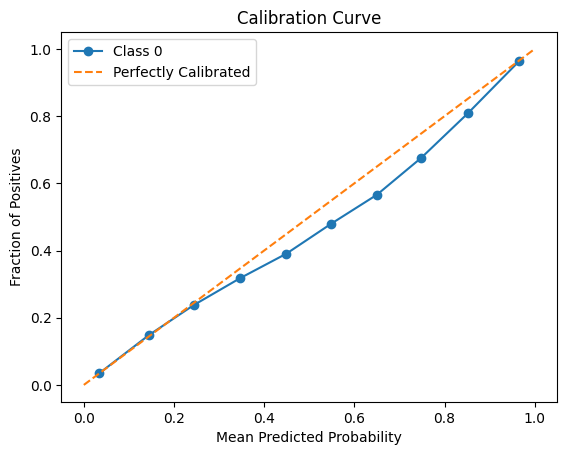

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import torch

def binarize(target, c):
    return np.array([1 if t == c else 0 for t in target])

Model.eval()  # Set model to evaluation mode
y_true = []
y_probabilities = []

# Iterate over test_loader to get predictions and true labels
for inputs, labels in Noise_test_loader:
    inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

    # Forward pass
    outputs = Model(inputs)
    probabilities = outputs[0]
    
    y_true.extend(labels.cpu().numpy())  # Collect true labels
    y_probabilities.extend(probabilities[:, 0].detach().cpu().numpy())  # Collect probabilities for class 0

y_true_binarized = binarize(y_true, 0)

# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_true_binarized, y_probabilities, n_bins=10)

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o', label="Class")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()